## 导入必要的库

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#画图用

import random
import numpy as np
import pandas as pd
from scipy import stats
#数据处理用

from tqdm import trange
#进度可视化用

import torch
import torch.nn as nn
#产业分布距离测算用torch算起来更快一点

#没有的库自己pip install安装上就行。

### 基于Sinkhorn求解Wasserstein距离

In [2]:
#应用Sinkhorn求解Wasserstein距离是一个应用非常广泛的方法。目前人脸识别、GAN生成等领域都有应用。
#网上有不错的开源代码，我们参考应用。

# Adapted from https://github.com/gpeyre/SinkhornAutoDiff
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).squeeze()

        u = torch.zeros_like(mu)
        v = torch.zeros_like(nu)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=2):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

### 定义空间分布改造可视化函数

In [3]:
def show_assignments(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.title('Assignments')
    plt.scatter(a[:, 0], a[:, 1])
    plt.scatter(b[:, 0], b[:, 1])
    plt.axis('off')

---
## 产业分布距离测算

**我们在这里首先使用青海省的数据作为测试。**

**我们在这里先以以下两个产业为例，完成整个产业距离测算和产业共聚指数的计算。**

In [4]:
#读取两个产业的坐标数据。
data1 = pd.read_excel('测试数据/制造业/青海省（部分数据）/1-/纺织业.xlsx',header = None).dropna()
data2 = pd.read_excel('测试数据/制造业/青海省（部分数据）/1-/纺织服装、服饰业.xlsx',header = None).dropna()

In [5]:
#此时 a和b 分别代表了这两个产业的全部企业的经纬度坐标。
a = data1.values[:,:2]
b = data2.values[:,:2]

#输出表示a产业有175个企业，b产业有466个企业。
a.shape,b.shape

((175, 2), (466, 2))

In [6]:
## 定义一个数据读取和处理函数，便于后续大规模计算时利用

#该函数输入excel地址，返回该excel对应的行业的全部企业的经纬度矩阵。
def process_data(path):
    temp = pd.read_excel(path,header = None).dropna()
    return temp.values[:,:2]


Sinkhorn distance: 1.718


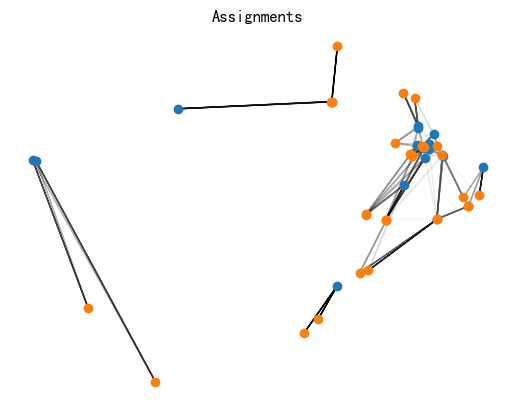

In [7]:
#取上述ab产业的部分企业点进行产业分布距离测算。随便取了一些点简单做一个测试和可视化，可以看看图。
x = torch.tensor(a, dtype=torch.float)[:20]
y = torch.tensor(b, dtype=torch.float)[:30]

sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))
show_assignments(a[:20], b[:30], P)
#该图片是对两个产业的在空间上将产业 a 的空间分布改造为产业 b 的空间分布的最小成本。

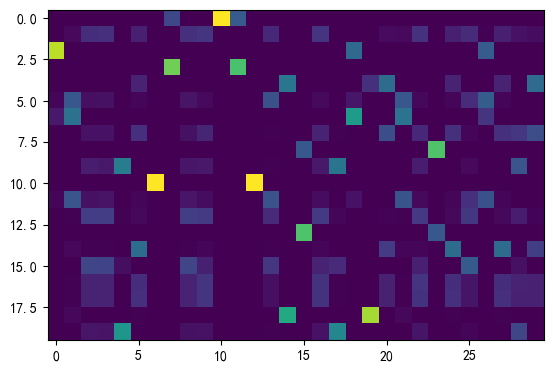

In [8]:
#转移矩阵，或者说代价值。比如[i,j]位置可以理解为将a产业的i企业迁移到b产业的j企业位置的代价。
#可以作为论文的一个补充，倒也没什么特别重要。
plt.imshow(P)

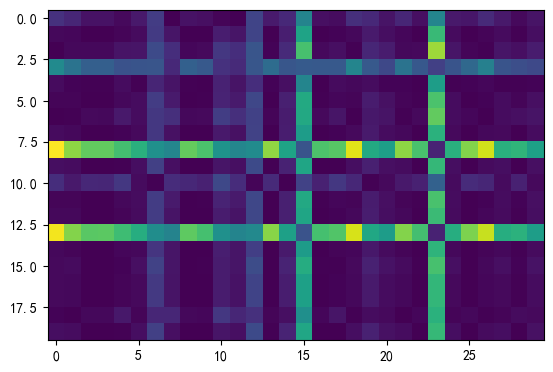

In [9]:
#同上。
plt.imshow(C)

### 基于 Wasserstein 距离的产业分布距离测算

In [10]:
#输入点数太多计算量过大会引起程序崩溃，所以我们需要多次采样限定数量的点对，重复执行200次，可以任意修改。
NUM = 200
threshold = 30
#这是因为在我这的电脑上点对超过30-50会崩溃，这个数字可以自行修改，如果电脑性能够好，可以调大。
#我这里是告诉你这里程序设计的意义，可以自行测试调整具体的参数。

final_Wjk = []
for i in trange(NUM):
    if len(a) > threshold:
        x = torch.tensor(a[random.sample(range(len(a)),threshold)], dtype=torch.float)
    else:
        x = torch.tensor(a, dtype=torch.float)
    
    if len(b) > threshold:
        y = torch.tensor(b[random.sample(range(len(b)),threshold)], dtype=torch.float)
    else:
        y = torch.tensor(b, dtype=torch.float)
        
    sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
    dist, P, C = sinkhorn(x, y)
    
    final_Wjk.append(dist.item())
print('true_distance:',np.mean(final_Wjk))
true_distance = np.mean(final_Wjk)

#你可以多次运行查看输出，结果基本稳定，佐证了这样操作的合理性。

100%|██████████████████████████████████████| 200/200 [00:02<00:00, 70.13it/s]

true_distance: 2.1425154301524163


In [11]:
#将上面计算distance的过程封装成函数，便于我们后续反事实样本的测试。

#该函数输入两组产业的全部企业经纬度，输出这两个产业的分布距离。
def get_distance(a,b,NUM = 100,threshold = 30):
    #sample_num = np.max((np.max((len(a),len(b)))//threshold,1))
    final_Wjk = []
    for i in range(NUM):
        if len(a) > threshold:
            x = torch.tensor(a[random.sample(range(len(a)),threshold)], dtype=torch.float)
        else:
            x = torch.tensor(a, dtype=torch.float)
        if len(b) > threshold:
            y = torch.tensor(b[random.sample(range(len(b)),threshold)], dtype=torch.float)
        else:
            y = torch.tensor(b, dtype=torch.float)
            
        sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None)
        dist, P, C = sinkhorn(x, y)
        final_Wjk.append(dist.item())
    return np.mean(final_Wjk)

### 依据统计意义的反事实样本集的产业共聚指数构建

In [12]:
#获取该区域全部企业的坐标，作为反事实样本蒙特卡洛抽样的数据集。
#因为我们需要保证模拟的企业位置也是合理的，那么最优的方式就是从已有的企业坐标中进行蒙特卡洛。
#我们将全部青海省的各行业的企业坐标全部获取并且完成合并。

import glob
path_list1 = glob.glob('测试数据/物流业/青海省（部分数据）/1/*')
path_list2 = glob.glob('测试数据/制造业/青海省（部分数据）/1-/*')
path_list = path_list1 + path_list2
path_list

['测试数据/物流业/青海省（部分数据）/1/多式联运和运输代理业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/水上运输业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/管道运输业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/装卸搬运和仓储业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/邮政业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/铁路运输业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/航空运输业.xlsx',
 '测试数据/物流业/青海省（部分数据）/1/道路运输业.xlsx',
 '测试数据/制造业/青海省（部分数据）/1-/电气机械和器材制造业.xlsx',
 '测试数据/制造业/青海省（部分数据）/1-/纺织服装、服饰业.xlsx',
 '测试数据/制造业/青海省（部分数据）/1-/非金属矿物制品业.xlsx',
 '测试数据/制造业/青海省（部分数据）/1-/纺织业.xlsx']

In [13]:
all_location = np.zeros((0,2)) #先新建一个数组准备往里面传。
for path in path_list:
    temp = pd.read_excel(path,header = None).dropna().values ##这批测试数据的特点，因为这些excel文件有的前几行是logo读进来就是缺失值，首先drop掉。
    temp1 = temp[:,0] #获取该excel文档的每个企业位置的平均经度
    temp2 = temp[:,1] #获取该excel文档的每个企业位置的平均维度
    all_location = np.vstack((all_location,np.vstack((temp1,temp2)).T)) #将经纬度信息拼接到总数组里。

In [14]:
all_location.shape #代表我们现在搞到青海省全部6029个企业位置。

(6029, 2)

In [15]:
false_distance = []
Mentakalo_NUM = 1000 #论文中指定的生成1000组反事实样本。
for i in trange(Mentakalo_NUM):
    #首先获取和b一样数据量的随机采样结果。
    false_b = all_location[random.sample(range(len(all_location)),len(b))]
    #然后调用上面定义好的距离计算方式，计算产业a和蒙特卡洛模拟生成的false_b的距离，运行1000次并保存。
    false_distance.append(get_distance(a,false_b))

100%|████████████████████████████████████| 1000/1000 [22:52<00:00,  1.37s/it]


In [16]:
#对false_distance 和上面计算得到的true_distance作假设检验，得到共聚指数。
n = np.sum(true_distance < false_distance)
print('%.2f%%的置信度拒绝原假设。'%(n/Mentakalo_NUM * 100))
print('共聚指数为%.3f'%(n/Mentakalo_NUM))

23.00%的置信度拒绝原假设。
共聚指数为0.230


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(2.1425154301524163, 1.5, 'true_distance')

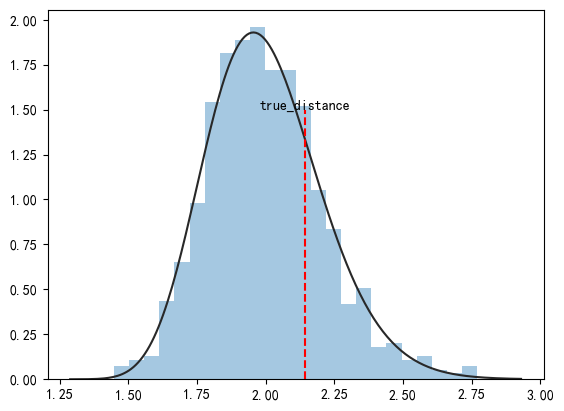

In [17]:
#简单对反事实数据做一个可视化，竖红线是我们的真实产业分布距离，而分布图则是假距离的分布。  
#可以作为论文的补充。
sns.distplot(false_distance,kde=False, fit=stats.gamma)#曲线做了fit拟合
plt.vlines(true_distance, 0, 1.5, colors = "r", linestyles = "dashed")
plt.text(true_distance, 1.5, 'true_distance', horizontalalignment='center')

# 下面开始批量计算。

---
## 计算北京市内的两个产业之间的共聚指标

In [18]:
import glob
path_list1 = glob.glob('测试数据/物流业/北京市/*')
path_list2 = glob.glob('测试数据/制造业/北京市/*')
path_list = path_list1 + path_list2
#！！注意！，我为了节省时间只跑了青海省内的四个产业，因为全部产业跑的话要跑100+次实验。
#你后续只需要把[:4]去掉即可，就能跑全部12个产业彼此之间的全部产业共聚指数了。


def process_data_beijing(path):
    temp = pd.read_excel(path,header = None).dropna()
    return temp.values[:,-4:-2].astype(float)


all_location1 = np.zeros((0,2)) #先新建一个数组准备往里面传。
all_location2 = np.zeros((0,2)) #先新建一个数组准备往里面传。

for path in path_list1:
    temp = process_data_beijing(path)
    all_location1 = np.vstack((all_location1,temp)) #将经纬度信息拼接到总数组里。
    
for path in path_list2:
    temp = process_data_beijing(path)
    all_location2 = np.vstack((all_location2,temp)) #将经纬度信息拼接到总数组里。    

In [19]:
length1 = len(path_list1)
length2 = len(path_list2)
total_v = np.zeros((length1,length2))#定义一个存储矩阵。
total_v_op = np.zeros((length2,length1))#定义一个存储矩阵。

for i in range(length1):
    for j in range(length2):
        
        name_a = path_list1[i].split('/')[-1].split('.')[0] #把产业名字保存下里，方便后面输出直观。
        name_b = path_list2[j].split('/')[-1].split('.')[0]
        
        #if i==j:
        #    continue #自己和自己就不用计算啦。 所以在后面的热力图中对角线都是0，因为自己和自己没有计算的必要。
        
        #计算行业i和行业j的真实距离
        a = process_data_beijing(path_list1[i])
        b = process_data_beijing(path_list2[j])
        if len(b) == 1:
            b = np.vstack((b,b))
            
        true_distance = get_distance(a,b)
        
        #蒙特卡洛模拟行业j的反事实数据100组 注：文中跑的是1000次，我们为了加快测试速度，改成生成100组反事实数据。你后续可以改成1000挂着跑就行了。
        false_distance = []
        Mentakalo_NUM2 = 5
        for _ in trange(Mentakalo_NUM2):
            #首先获取和b一样数据量的随机采样结果。
            false_b = all_location2[random.sample(range(len(all_location2)),len(b))]
            #然后调用上面定义好的距离计算方式，计算产业a和蒙特卡洛模拟生成的false_b的距离，运行Mentakalo_NUM2次并保存。
            false_distance.append(get_distance(a,false_b))
        
        #计算这Mentakalo_NUM2组行业j假数据与行业i的虚假距离
        n = np.sum(true_distance < false_distance)
        print('%s 和 %s 的共聚指数为 %.3f'%(name_a,name_b,n/Mentakalo_NUM2))

        #完成假设检验，并将共聚指标存储到存储矩阵中。
        total_v[i,j] = n/Mentakalo_NUM2
        
for j in range(length2):
    for i in range(length1):
        
        name_a = path_list2[j].split('/')[-1].split('.')[0] #把产业名字保存下里，方便后面输出直观。
        name_b = path_list1[i].split('/')[-1].split('.')[0]
        
        #if i==j:
        #    continue #自己和自己就不用计算啦。 所以在后面的热力图中对角线都是0，因为自己和自己没有计算的必要。
        
        #计算行业i和行业j的真实距离
        a = process_data_beijing(path_list2[j])
        b = process_data_beijing(path_list1[i])
        if len(b) == 1:
            b = np.vstack((b,b))
            
        true_distance = get_distance(a,b)
        
        #蒙特卡洛模拟行业j的反事实数据100组 注：文中跑的是1000次，我们为了加快测试速度，改成生成100组反事实数据。你后续可以改成1000挂着跑就行了。
        false_distance = []
        Mentakalo_NUM2 = 5
        for _ in trange(Mentakalo_NUM2):
            #首先获取和b一样数据量的随机采样结果。
            false_b = all_location1[random.sample(range(len(all_location1)),len(b))]
            #然后调用上面定义好的距离计算方式，计算产业a和蒙特卡洛模拟生成的false_b的距离，运行Mentakalo_NUM2次并保存。
            false_distance.append(get_distance(a,false_b))
        
        #计算这Mentakalo_NUM2组行业j假数据与行业i的虚假距离
        n = np.sum(true_distance < false_distance)
        print('%s 和 %s 的共聚指数为 %.3f'%(name_a,name_b,n/Mentakalo_NUM2))

        #完成假设检验，并将共聚指标存储到存储矩阵中。
        total_v_op[j,i] = n/Mentakalo_NUM2

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


多式联运和运输代理业 和 汽车制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]


多式联运和运输代理业 和 家具制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


多式联运和运输代理业 和 金属制品、机械和设备修理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


多式联运和运输代理业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.35it/s]


多式联运和运输代理业 和 纺织服装、服饰业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]


多式联运和运输代理业 和 仪器仪表制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


多式联运和运输代理业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


多式联运和运输代理业 和 其他制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


多式联运和运输代理业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]


多式联运和运输代理业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.26it/s]


多式联运和运输代理业 和 通用设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.62it/s]


多式联运和运输代理业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


多式联运和运输代理业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


多式联运和运输代理业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.51it/s]


多式联运和运输代理业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


多式联运和运输代理业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


多式联运和运输代理业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


多式联运和运输代理业 和 专用设备制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


多式联运和运输代理业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


多式联运和运输代理业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s]


多式联运和运输代理业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]


多式联运和运输代理业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.41it/s]


多式联运和运输代理业 和 金属制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


多式联运和运输代理业 和 纺织业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


多式联运和运输代理业 和 有色金属冶炼和压延加工业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.18it/s]


多式联运和运输代理业 和 食品制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.70it/s]


多式联运和运输代理业 和 农副食品加工业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


多式联运和运输代理业 和 化学纤维制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.61it/s]


多式联运和运输代理业 和 医药制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.05it/s]


多式联运和运输代理业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


多式联运和运输代理业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


水上运输业 和 汽车制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


水上运输业 和 家具制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


水上运输业 和 金属制品、机械和设备修理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


水上运输业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


水上运输业 和 纺织服装、服饰业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.68it/s]


水上运输业 和 仪器仪表制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.36it/s]


水上运输业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.82it/s]


水上运输业 和 其他制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


水上运输业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


水上运输业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.35it/s]


水上运输业 和 通用设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.40it/s]


水上运输业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


水上运输业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]


水上运输业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.78it/s]


水上运输业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.86it/s]


水上运输业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15.59it/s]


水上运输业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


水上运输业 和 专用设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]


水上运输业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


水上运输业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


水上运输业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.55it/s]


水上运输业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


水上运输业 和 金属制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


水上运输业 和 纺织业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


水上运输业 和 有色金属冶炼和压延加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


水上运输业 和 食品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]


水上运输业 和 农副食品加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


水上运输业 和 化学纤维制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s]


水上运输业 和 医药制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]


水上运输业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.35it/s]


水上运输业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15.75it/s]


管道运输业 和 汽车制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.70it/s]


管道运输业 和 家具制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15.45it/s]


管道运输业 和 金属制品、机械和设备修理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.39it/s]


管道运输业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.64it/s]


管道运输业 和 纺织服装、服饰业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.51it/s]


管道运输业 和 仪器仪表制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.49it/s]


管道运输业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.54it/s]


管道运输业 和 其他制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.53it/s]


管道运输业 和 非金属矿物制品业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.64it/s]


管道运输业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.57it/s]


管道运输业 和 通用设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.21it/s]


管道运输业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.12it/s]


管道运输业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.16it/s]


管道运输业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.77it/s]


管道运输业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.95it/s]


管道运输业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 19.69it/s]


管道运输业 和 烟草制品业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.27it/s]


管道运输业 和 专用设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.92it/s]


管道运输业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.92it/s]


管道运输业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.02it/s]


管道运输业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.59it/s]


管道运输业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.63it/s]


管道运输业 和 金属制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.77it/s]


管道运输业 和 纺织业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.03it/s]


管道运输业 和 有色金属冶炼和压延加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.55it/s]


管道运输业 和 食品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.47it/s]


管道运输业 和 农副食品加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.68it/s]


管道运输业 和 化学纤维制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.16it/s]


管道运输业 和 医药制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.71it/s]


管道运输业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 17.61it/s]


管道运输业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.09it/s]


装卸搬运和仓储业 和 汽车制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


装卸搬运和仓储业 和 家具制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.91it/s]


装卸搬运和仓储业 和 金属制品、机械和设备修理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


装卸搬运和仓储业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.86it/s]


装卸搬运和仓储业 和 纺织服装、服饰业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.26it/s]


装卸搬运和仓储业 和 仪器仪表制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.08it/s]


装卸搬运和仓储业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s]


装卸搬运和仓储业 和 其他制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


装卸搬运和仓储业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


装卸搬运和仓储业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.06it/s]


装卸搬运和仓储业 和 通用设备制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


装卸搬运和仓储业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


装卸搬运和仓储业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


装卸搬运和仓储业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


装卸搬运和仓储业 和 计算机、通信和其他电子设备制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


装卸搬运和仓储业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


装卸搬运和仓储业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


装卸搬运和仓储业 和 专用设备制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.03it/s]


装卸搬运和仓储业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


装卸搬运和仓储业 和 印刷和记录媒介复制业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


装卸搬运和仓储业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


装卸搬运和仓储业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


装卸搬运和仓储业 和 金属制品业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


装卸搬运和仓储业 和 纺织业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


装卸搬运和仓储业 和 有色金属冶炼和压延加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


装卸搬运和仓储业 和 食品制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


装卸搬运和仓储业 和 农副食品加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


装卸搬运和仓储业 和 化学纤维制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]


装卸搬运和仓储业 和 医药制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


装卸搬运和仓储业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.24it/s]


装卸搬运和仓储业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


邮政业 和 汽车制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


邮政业 和 家具制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


邮政业 和 金属制品、机械和设备修理业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


邮政业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


邮政业 和 纺织服装、服饰业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


邮政业 和 仪器仪表制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


邮政业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


邮政业 和 其他制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


邮政业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


邮政业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


邮政业 和 通用设备制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


邮政业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


邮政业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


邮政业 和 黑色金属冶炼和压延加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


邮政业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


邮政业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.90it/s]


邮政业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


邮政业 和 专用设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


邮政业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


邮政业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


邮政业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


邮政业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


邮政业 和 金属制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


邮政业 和 纺织业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.53it/s]


邮政业 和 有色金属冶炼和压延加工业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


邮政业 和 食品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


邮政业 和 农副食品加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


邮政业 和 化学纤维制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


邮政业 和 医药制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


邮政业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


邮政业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.98it/s]


铁路运输业 和 汽车制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.22it/s]


铁路运输业 和 家具制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.63it/s]


铁路运输业 和 金属制品、机械和设备修理业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.16it/s]


铁路运输业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.03it/s]


铁路运输业 和 纺织服装、服饰业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.46it/s]


铁路运输业 和 仪器仪表制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.59it/s]


铁路运输业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.10it/s]


铁路运输业 和 其他制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.00it/s]


铁路运输业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.88it/s]


铁路运输业 和 化学原料和化学制品制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.14it/s]


铁路运输业 和 通用设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.38it/s]


铁路运输业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.54it/s]


铁路运输业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.20it/s]


铁路运输业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.93it/s]


铁路运输业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.89it/s]


铁路运输业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.00it/s]


铁路运输业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.11it/s]


铁路运输业 和 专用设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 13.04it/s]


铁路运输业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.88it/s]


铁路运输业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.66it/s]


铁路运输业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.60it/s]


铁路运输业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]


铁路运输业 和 金属制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.48it/s]


铁路运输业 和 纺织业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s]


铁路运输业 和 有色金属冶炼和压延加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.51it/s]


铁路运输业 和 食品制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.52it/s]


铁路运输业 和 农副食品加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 14.36it/s]


铁路运输业 和 化学纤维制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


铁路运输业 和 医药制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 12.61it/s]


铁路运输业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]


铁路运输业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


航空运输业 和 汽车制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


航空运输业 和 家具制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


航空运输业 和 金属制品、机械和设备修理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


航空运输业 和 电气机械和器材制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


航空运输业 和 纺织服装、服饰业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


航空运输业 和 仪器仪表制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


航空运输业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


航空运输业 和 其他制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


航空运输业 和 非金属矿物制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


航空运输业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


航空运输业 和 通用设备制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


航空运输业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


航空运输业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


航空运输业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


航空运输业 和 计算机、通信和其他电子设备制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


航空运输业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 14.37it/s]


航空运输业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


航空运输业 和 专用设备制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


航空运输业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


航空运输业 和 印刷和记录媒介复制业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


航空运输业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


航空运输业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


航空运输业 和 金属制品业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


航空运输业 和 纺织业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


航空运输业 和 有色金属冶炼和压延加工业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


航空运输业 和 食品制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


航空运输业 和 农副食品加工业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


航空运输业 和 化学纤维制造业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


航空运输业 和 医药制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


航空运输业 和 废弃资源综合利用业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


航空运输业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


道路运输业 和 汽车制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


道路运输业 和 家具制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.02it/s]


道路运输业 和 金属制品、机械和设备修理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


道路运输业 和 电气机械和器材制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


道路运输业 和 纺织服装、服饰业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


道路运输业 和 仪器仪表制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


道路运输业 和 橡胶和塑料制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


道路运输业 和 其他制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


道路运输业 和 非金属矿物制品业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


道路运输业 和 化学原料和化学制品制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


道路运输业 和 通用设备制造业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


道路运输业 和 皮革、毛皮、羽毛及其制品和制鞋业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


道路运输业 和 造纸和纸制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.88it/s]


道路运输业 和 黑色金属冶炼和压延加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


道路运输业 和 计算机、通信和其他电子设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.72it/s]


道路运输业 和 文教、工美、体育和娱乐用品制造业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


道路运输业 和 烟草制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


道路运输业 和 专用设备制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s]


道路运输业 和 木材加工和木、竹、藤、棕、草制品业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s]


道路运输业 和 印刷和记录媒介复制业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s]


道路运输业 和 铁路、船舶、航空航天和其他运输设备制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


道路运输业 和 石油、煤炭及其他燃料加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


道路运输业 和 金属制品业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


道路运输业 和 纺织业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


道路运输业 和 有色金属冶炼和压延加工业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


道路运输业 和 食品制造业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


道路运输业 和 农副食品加工业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


道路运输业 和 化学纤维制造业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


道路运输业 和 医药制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


道路运输业 和 废弃资源综合利用业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


道路运输业 和 酒、饮料和精制茶制造业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


汽车制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


汽车制造业 和 水上运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


汽车制造业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


汽车制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


汽车制造业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


汽车制造业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


汽车制造业 和 航空运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


汽车制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


家具制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


家具制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


家具制造业 和 管道运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


家具制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


家具制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


家具制造业 和 铁路运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


家具制造业 和 航空运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.75it/s]


家具制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


金属制品、机械和设备修理业 和 多式联运和运输代理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.59it/s]


金属制品、机械和设备修理业 和 水上运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


金属制品、机械和设备修理业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s]


金属制品、机械和设备修理业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.25it/s]


金属制品、机械和设备修理业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s]


金属制品、机械和设备修理业 和 铁路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


金属制品、机械和设备修理业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]


金属制品、机械和设备修理业 和 道路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


电气机械和器材制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


电气机械和器材制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


电气机械和器材制造业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s]


电气机械和器材制造业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


电气机械和器材制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


电气机械和器材制造业 和 铁路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


电气机械和器材制造业 和 航空运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.24it/s]


电气机械和器材制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


纺织服装、服饰业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


纺织服装、服饰业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


纺织服装、服饰业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


纺织服装、服饰业 和 装卸搬运和仓储业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


纺织服装、服饰业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


纺织服装、服饰业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


纺织服装、服饰业 和 航空运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s]


纺织服装、服饰业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


仪器仪表制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


仪器仪表制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


仪器仪表制造业 和 管道运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


仪器仪表制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


仪器仪表制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


仪器仪表制造业 和 铁路运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


仪器仪表制造业 和 航空运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


仪器仪表制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


橡胶和塑料制品业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


橡胶和塑料制品业 和 水上运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


橡胶和塑料制品业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


橡胶和塑料制品业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


橡胶和塑料制品业 和 邮政业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


橡胶和塑料制品业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


橡胶和塑料制品业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.18it/s]


橡胶和塑料制品业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


其他制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


其他制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


其他制造业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


其他制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


其他制造业 和 邮政业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


其他制造业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


其他制造业 和 航空运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


其他制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


非金属矿物制品业 和 多式联运和运输代理业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


非金属矿物制品业 和 水上运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


非金属矿物制品业 和 管道运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


非金属矿物制品业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


非金属矿物制品业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


非金属矿物制品业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


非金属矿物制品业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


非金属矿物制品业 和 道路运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


化学原料和化学制品制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


化学原料和化学制品制造业 和 水上运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.53it/s]


化学原料和化学制品制造业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


化学原料和化学制品制造业 和 装卸搬运和仓储业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


化学原料和化学制品制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]


化学原料和化学制品制造业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


化学原料和化学制品制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.91it/s]


化学原料和化学制品制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


通用设备制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


通用设备制造业 和 水上运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.06it/s]


通用设备制造业 和 管道运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


通用设备制造业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


通用设备制造业 和 邮政业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


通用设备制造业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


通用设备制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


通用设备制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.04it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 航空运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.52it/s]


皮革、毛皮、羽毛及其制品和制鞋业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


造纸和纸制品业 和 多式联运和运输代理业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.74it/s]


造纸和纸制品业 和 水上运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


造纸和纸制品业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.71it/s]


造纸和纸制品业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.87it/s]


造纸和纸制品业 和 邮政业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


造纸和纸制品业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


造纸和纸制品业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


造纸和纸制品业 和 道路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.80it/s]


黑色金属冶炼和压延加工业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


黑色金属冶炼和压延加工业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


黑色金属冶炼和压延加工业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.29it/s]


黑色金属冶炼和压延加工业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


黑色金属冶炼和压延加工业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


黑色金属冶炼和压延加工业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


黑色金属冶炼和压延加工业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


黑色金属冶炼和压延加工业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


计算机、通信和其他电子设备制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


计算机、通信和其他电子设备制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


计算机、通信和其他电子设备制造业 和 管道运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


计算机、通信和其他电子设备制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.53it/s]


计算机、通信和其他电子设备制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


计算机、通信和其他电子设备制造业 和 铁路运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


计算机、通信和其他电子设备制造业 和 航空运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]


计算机、通信和其他电子设备制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


文教、工美、体育和娱乐用品制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s]


文教、工美、体育和娱乐用品制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


文教、工美、体育和娱乐用品制造业 和 管道运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.87it/s]


文教、工美、体育和娱乐用品制造业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


文教、工美、体育和娱乐用品制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


文教、工美、体育和娱乐用品制造业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


文教、工美、体育和娱乐用品制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s]


文教、工美、体育和娱乐用品制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 20.17it/s]


烟草制品业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 20.72it/s]


烟草制品业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 24.89it/s]


烟草制品业 和 管道运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 18.20it/s]


烟草制品业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 20.08it/s]


烟草制品业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 23.93it/s]


烟草制品业 和 铁路运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 21.09it/s]


烟草制品业 和 航空运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 16.83it/s]


烟草制品业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


专用设备制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s]


专用设备制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


专用设备制造业 和 管道运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


专用设备制造业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


专用设备制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


专用设备制造业 和 铁路运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


专用设备制造业 和 航空运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s]


专用设备制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


木材加工和木、竹、藤、棕、草制品业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


木材加工和木、竹、藤、棕、草制品业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.31it/s]


木材加工和木、竹、藤、棕、草制品业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


木材加工和木、竹、藤、棕、草制品业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


木材加工和木、竹、藤、棕、草制品业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


木材加工和木、竹、藤、棕、草制品业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


木材加工和木、竹、藤、棕、草制品业 和 航空运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]


木材加工和木、竹、藤、棕、草制品业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.61it/s]


印刷和记录媒介复制业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


印刷和记录媒介复制业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


印刷和记录媒介复制业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


印刷和记录媒介复制业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.73it/s]


印刷和记录媒介复制业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


印刷和记录媒介复制业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


印刷和记录媒介复制业 和 航空运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


印刷和记录媒介复制业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.98it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.29it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 铁路运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


铁路、船舶、航空航天和其他运输设备制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


石油、煤炭及其他燃料加工业 和 多式联运和运输代理业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


石油、煤炭及其他燃料加工业 和 水上运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


石油、煤炭及其他燃料加工业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


石油、煤炭及其他燃料加工业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


石油、煤炭及其他燃料加工业 和 邮政业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


石油、煤炭及其他燃料加工业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


石油、煤炭及其他燃料加工业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


石油、煤炭及其他燃料加工业 和 道路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


金属制品业 和 多式联运和运输代理业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


金属制品业 和 水上运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


金属制品业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


金属制品业 和 装卸搬运和仓储业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


金属制品业 和 邮政业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


金属制品业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


金属制品业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.43it/s]


金属制品业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.70it/s]


纺织业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


纺织业 和 水上运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


纺织业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


纺织业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


纺织业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


纺织业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.37it/s]


纺织业 和 航空运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]


纺织业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


有色金属冶炼和压延加工业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


有色金属冶炼和压延加工业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


有色金属冶炼和压延加工业 和 管道运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


有色金属冶炼和压延加工业 和 装卸搬运和仓储业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


有色金属冶炼和压延加工业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


有色金属冶炼和压延加工业 和 铁路运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


有色金属冶炼和压延加工业 和 航空运输业 的共聚指数为 0.400


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.51it/s]


有色金属冶炼和压延加工业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.33it/s]


食品制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s]


食品制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


食品制造业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


食品制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s]


食品制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.44it/s]


食品制造业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.83it/s]


食品制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


食品制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.90it/s]


农副食品加工业 和 多式联运和运输代理业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


农副食品加工业 和 水上运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


农副食品加工业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.95it/s]


农副食品加工业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


农副食品加工业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


农副食品加工业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


农副食品加工业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


农副食品加工业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.35it/s]


化学纤维制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


化学纤维制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15.38it/s]


化学纤维制造业 和 管道运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


化学纤维制造业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.61it/s]


化学纤维制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15.04it/s]


化学纤维制造业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


化学纤维制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


化学纤维制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s]


医药制造业 和 多式联运和运输代理业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s]


医药制造业 和 水上运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


医药制造业 和 管道运输业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.07it/s]


医药制造业 和 装卸搬运和仓储业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s]


医药制造业 和 邮政业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]


医药制造业 和 铁路运输业 的共聚指数为 0.600


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


医药制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]


医药制造业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.72it/s]


废弃资源综合利用业 和 多式联运和运输代理业 的共聚指数为 0.800


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.68it/s]


废弃资源综合利用业 和 水上运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s]


废弃资源综合利用业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.78it/s]


废弃资源综合利用业 和 装卸搬运和仓储业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.40it/s]


废弃资源综合利用业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


废弃资源综合利用业 和 铁路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


废弃资源综合利用业 和 航空运输业 的共聚指数为 1.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.38it/s]


废弃资源综合利用业 和 道路运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.42it/s]


酒、饮料和精制茶制造业 和 多式联运和运输代理业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s]


酒、饮料和精制茶制造业 和 水上运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


酒、饮料和精制茶制造业 和 管道运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


酒、饮料和精制茶制造业 和 装卸搬运和仓储业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.89it/s]


酒、饮料和精制茶制造业 和 邮政业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


酒、饮料和精制茶制造业 和 铁路运输业 的共聚指数为 0.200


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  8.21it/s]


酒、饮料和精制茶制造业 和 航空运输业 的共聚指数为 0.000


100%|██████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]

酒、饮料和精制茶制造业 和 道路运输业 的共聚指数为 1.000


In [20]:
total_v_op

array([[1. , 0.6, 0. , 1. , 0. , 0. , 1. , 0. ],
       [1. , 1. , 0.8, 1. , 1. , 0.8, 0.4, 0. ],
       [0. , 0.6, 0.2, 0. , 1. , 0.4, 0. , 0.4],
       [1. , 1. , 0. , 0.8, 1. , 0.4, 0.2, 0. ],
       [1. , 1. , 0. , 0.4, 0. , 0. , 0.6, 0. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 0.6, 0. ],
       [1. , 0. , 0.2, 0.8, 0.4, 0. , 0. , 0. ],
       [1. , 1. , 0. , 1. , 0.8, 0. , 0.6, 0. ],
       [0.2, 0.4, 0.4, 0. , 0. , 0. , 0. , 0.6],
       [1. , 0.8, 0.2, 0.2, 1. , 0. , 0. , 0. ],
       [1. , 0.8, 0.4, 0. , 0.2, 0. , 0. , 0. ],
       [1. , 1. , 0. , 0.8, 1. , 0. , 0.2, 0. ],
       [0.8, 0.2, 0. , 1. , 0.6, 0. , 0. , 0.4],
       [1. , 1. , 0.2, 1. , 1. , 0. , 0. , 0. ],
       [1. , 1. , 0.8, 1. , 1. , 0.8, 0.4, 0. ],
       [1. , 1. , 0.4, 0. , 1. , 0.2, 0. , 0. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. ],
       [1. , 1. , 0.4, 0.8, 1. , 0.6, 0.2, 0. ],
       [1. , 1. , 0. , 1. , 1. , 0. , 0.2, 0. ],
       [1. , 1. , 0.2, 1. , 1. , 0.2, 0.8, 0. ],
       [1. , 1. , 0.

In [21]:
label_list1 = list(map(lambda x: x.split('/')[-1].split('.')[0],path_list1))
label_list2 = list(map(lambda x: x.split('/')[-1].split('.')[0],path_list2))

save_pd1 = pd.DataFrame(total_v,columns = label_list2,index = label_list1)
save_pd1.to_excel('beijing1.xlsx')

save_pd2 = pd.DataFrame(total_v_op,columns = label_list1,index = label_list2)
save_pd2.to_excel('beijing2.xlsx')

In [22]:
##解决中文不显示问题，解决方法很多，你也可以通过别的方式解决。
#from matplotlib.font_manager import FontProperties
#font = FontProperties(fname=r"SimHei.ttf", size=10)

# 定义热图的横纵坐标
#xLabel = list(map(lambda x: x.split('/')[-1].split('.')[0],path_list))
#yLabel = list(map(lambda x: x.split('/')[-1].split('.')[0],path_list))


# 作图阶段
#fig, ax = plt.subplots(figsize = (12,12),dpi =400)
# 定义横纵坐标的刻度
#ax.set_yticks(range(len(yLabel)))
#ax.set_yticklabels(yLabel, fontproperties=font)
#ax.set_xticks(range(len(xLabel)))
#ax.set_xticklabels(xLabel, fontproperties=font)
# 作图并选择热图的颜色填充风格，这里选择yLGn
#im = ax.imshow(total_v, cmap="YlGn")
# 增加右侧的颜色刻度条
#plt.colorbar(im)

# 填充数字
#for i in range(len(yLabel)):
#    for j in range(len(xLabel)):
#        ax.text(j, i, total_v[i, j],
#                ha="center", va="center", color="black")

# 增加标题
#font_title = FontProperties(fname=r"SimHei.ttf", size=20)  # 步骤二
#plt.title("共聚指数", fontdict={'size': 16}, fontproperties=font_title)
# show
#fig.tight_layout()
#plt.show()